In [1]:
# UNIVERSAL RANDOM FOREST ONE-CELL PIPELINE
# - Change TRAIN_PATH, TEST_PATH, TARGET only
# - Works for binary / multiclass classification and regression
# - Uses robust preprocessing, feature-selection, 3x RF ensemble, calibration, CV
# - Fills sample_submission.csv if present (probabilities for classification) or writes predictions

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# USER CONFIG - change only these
# ----------------------------
TRAIN_PATH = "/kaggle/input/ai-201-b-mse-2-aiml-c/train.csv"
TEST_PATH  = "/kaggle/input/ai-201-b-mse-2-aiml-c/test.csv"
SAMPLE_PATH = "/kaggle/input/ai-201-b-mse-2-aiml-c/sample_submission.csv"   # optional: used if provided
TARGET = "NObeyesdad"                       # change to your dataset's target column name
ID_COL = "id"                           # id column name

# ----------------------------
# Load data
# ----------------------------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_exists = Path(SAMPLE_PATH).exists()
if sample_exists:
    sample = pd.read_csv(SAMPLE_PATH)
else:
    sample = None

# ----------------------------
# Detect problem type
# ----------------------------
if TARGET not in train.columns:
    raise ValueError(f"TARGET '{TARGET}' not found in train columns: {train.columns.tolist()}")

# Quick heuristic to detect classification vs regression
y_raw = train[TARGET]
if y_raw.dtype == object or y_raw.nunique() <= 20:
    problem_type = "classification"
else:
    problem_type = "regression"

# ----------------------------
# Prepare X, y, X_test
# ----------------------------
X = train.drop([TARGET], axis=1)
y = y_raw.copy()
X_test = test.copy()

# remove id columns if present
if ID_COL in X.columns:
    X = X.drop([ID_COL], axis=1)
if ID_COL in X_test.columns:
    test_ids = X_test[ID_COL].copy()
    X_test = X_test.drop([ID_COL], axis=1)
else:
    test_ids = pd.Series(np.arange(len(X_test)), name="id")

# ----------------------------
# Encode target for classification
# ----------------------------
le = None
if problem_type == "classification":
    le = LabelEncoder()
    y = le.fit_transform(y)  # numeric labels 0..k-1

# ----------------------------
# Simple, safe missing value handling
# Numeric -> median, Categorical -> mode
# ----------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

for c in num_cols:
    med = X[c].median()
    X[c] = X[c].fillna(med)
    if c in X_test.columns:
        X_test[c] = X_test[c].fillna(med)
    else:
        # if test lacks column, later align will add zeros
        pass

for c in cat_cols:
    mode = X[c].mode(dropna=True)
    mode = mode[0] if len(mode)>0 else "missing"
    X[c] = X[c].fillna(mode).astype(str)
    if c in X_test.columns:
        X_test[c] = X_test[c].fillna(mode).astype(str)

# ----------------------------
# One-hot encode categorical features (safe OHE)
# ----------------------------
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# align train/test columns
X, X_test = X.align(X_test, join="left", axis=1)
X_test = X_test.fillna(0)

# ----------------------------
# Quick CV baseline (optional, fast)
# ----------------------------
print(f"Problem detected: {problem_type}. Train shape: {X.shape}, Test shape: {X_test.shape}")

# ----------------------------
# Feature importance selection using a small RF base (fast)
# ----------------------------
base_rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1) if problem_type=="classification" else RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
base_rf.fit(X, y)
importances = pd.Series(base_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Keep top features that contribute cumulatively to 0.98 importance or min threshold
cum = importances.cumsum()
keep = cum[cum <= 0.98].index.tolist()
# ensure at least top 10 features kept
if len(keep) < 10:
    keep = importances.iloc[:max(10, int(0.1*len(importances)))].index.tolist()

X = X[keep].copy()
X_test = X_test[keep].copy()
print(f"Kept {len(keep)} features")

# ----------------------------
# Split (stratify for classification)
# ----------------------------
if problem_type == "classification":
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.18, random_state=42, stratify=y)
else:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.18, random_state=42)

# ----------------------------
# Create 3 tuned RandomForest models (different seeds)
# ----------------------------
def make_rf(seed):
    if problem_type == "classification":
        return RandomForestClassifier(
            n_estimators=1200,
            max_depth=30,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            bootstrap=True,
            class_weight="balanced",
            random_state=seed,
            n_jobs=-1
        )
    else:
        return RandomForestRegressor(
            n_estimators=1000,
            max_depth=30,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features="sqrt",
            random_state=seed,
            n_jobs=-1
        )

rf1 = make_rf(42)
rf2 = make_rf(21)
rf3 = make_rf(99)

# ----------------------------
# For classification: use calibrated classifiers (sigmoid) for better probabilities
# For regression: train models directly
# ----------------------------
if problem_type == "classification":
    cal1 = CalibratedClassifierCV(rf1, method="sigmoid", cv=3)
    cal2 = CalibratedClassifierCV(rf2, method="sigmoid", cv=3)
    cal3 = CalibratedClassifierCV(rf3, method="sigmoid", cv=3)

    print("Training calibrated RF ensemble (this may take a while)...")
    cal1.fit(X_train, y_train)
    cal2.fit(X_train, y_train)
    cal3.fit(X_train, y_train)

    # validation
    p1 = cal1.predict_proba(X_val)
    p2 = cal2.predict_proba(X_val)
    p3 = cal3.predict_proba(X_val)
    p_avg = (p1 + p2 + p3) / 3
    val_pred = np.argmax(p_avg, axis=1)

    # metrics
    acc = accuracy_score(y_val, val_pred)
    try:
        roc = roc_auc_score(y_val, p_avg, multi_class="ovr")
    except:
        roc = None
    f1m = f1_score(y_val, val_pred, average="macro")
    print(f"Val accuracy: {acc:.4f}   macro-F1: {f1m:.4f}   ROC-AUC (ovr): {roc}")
    print("Confusion matrix (labels = encoded indices):")
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_val, val_pred))
    print(classification_report(y_val, val_pred))

    # train on full data
    print("Retraining calibrated ensemble on full data for final submission...")
    cal1.fit(X, y)
    cal2.fit(X, y)
    cal3.fit(X, y)

    # predict on test
    tp1 = cal1.predict_proba(X_test)
    tp2 = cal2.predict_proba(X_test)
    tp3 = cal3.predict_proba(X_test)
    tavg = (tp1 + tp2 + tp3) / 3

    # If sample submission exists, fill probabilities columns; else create label predictions column
    if sample is not None:
        # Try to detect sample columns (skip id column)
        cols = [c for c in sample.columns if c.lower() not in [ID_COL.lower()]]
        # If sample expects probabilities for each class, fill in same order as LabelEncoder classes
        if len(cols) == tavg.shape[1]:
            for idx, cls in enumerate(le.classes_):
                # column name fallback: TARGET_<class> or class name
                possible_names = [f"{TARGET}_{cls}", str(cls)]
                # find matching sample column (case-insensitive)
                matched = None
                for name in possible_names:
                    for c in sample.columns:
                        if c.lower() == name.lower():
                            matched = c
                            break
                    if matched: break
                # otherwise fallback to the cols order
                if matched is None:
                    matched = cols[idx]
                sample[matched] = tavg[:, idx]
            submission = sample
        else:
            # sample not matching columns -> write label predictions column
            preds_labels = le.inverse_transform(np.argmax(tavg, axis=1))
            submission = pd.DataFrame({ID_COL: test_ids, TARGET: preds_labels})
    else:
        preds_labels = le.inverse_transform(np.argmax(tavg, axis=1))
        submission = pd.DataFrame({ID_COL: test_ids, TARGET: preds_labels})

else:
    # regression path: train 3 regressors and average predictions
    print("Training RF regressors...")
    r1 = rf1.fit(X_train, y_train)
    r2 = rf2.fit(X_train, y_train)
    r3 = rf3.fit(X_train, y_train)

    # validation
    v1 = r1.predict(X_val)
    v2 = r2.predict(X_val)
    v3 = r3.predict(X_val)
    vavg = (v1 + v2 + v3) / 3.0
    rmse = mean_squared_error(y_val, vavg, squared=False)
    print(f"Val RMSE: {rmse:.4f}")

    # train on full
    r1.fit(X, y); r2.fit(X, y); r3.fit(X, y)
    t1 = r1.predict(X_test); t2 = r2.predict(X_test); t3 = r3.predict(X_test)
    tavg = (t1 + t2 + t3) / 3.0
    submission = pd.DataFrame({ID_COL: test_ids, TARGET: tavg})

# ----------------------------
# Save submission
# ----------------------------
out_name = "Predictions.csv"
submission.to_csv(out_name, index=False)
print("Saved:", out_name)


Problem detected: classification. Train shape: (18306, 22), Test shape: (4152, 22)
Kept 15 features
Training calibrated RF ensemble (this may take a while)...
Val accuracy: 0.8838   macro-F1: 0.8725   ROC-AUC (ovr): 0.9849684164732027
Confusion matrix (labels = encoded indices):
[[353  39   4   1   0   2   0]
 [ 16 428   3   0   0  33  10]
 [  0   2 404  13   3  13  33]
 [  0   0   9 491   1   0  11]
 [  1   0   0   1 638   1   0]
 [  2  41  10   2   2 291  43]
 [  0   7  27   2   0  51 308]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.92       399
           1       0.83      0.87      0.85       490
           2       0.88      0.86      0.87       468
           3       0.96      0.96      0.96       512
           4       0.99      1.00      0.99       641
           5       0.74      0.74      0.74       391
           6       0.76      0.78      0.77       395

    accuracy                           0.88      3296
   macro avg  

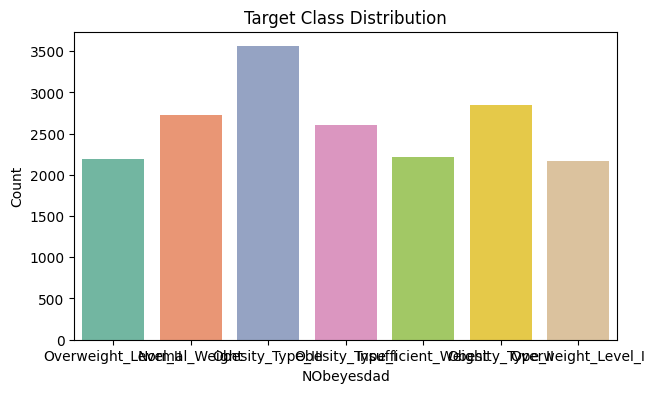

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,4))
sns.countplot(data=train, x=TARGET, palette="Set2")
plt.title("Target Class Distribution")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.show()


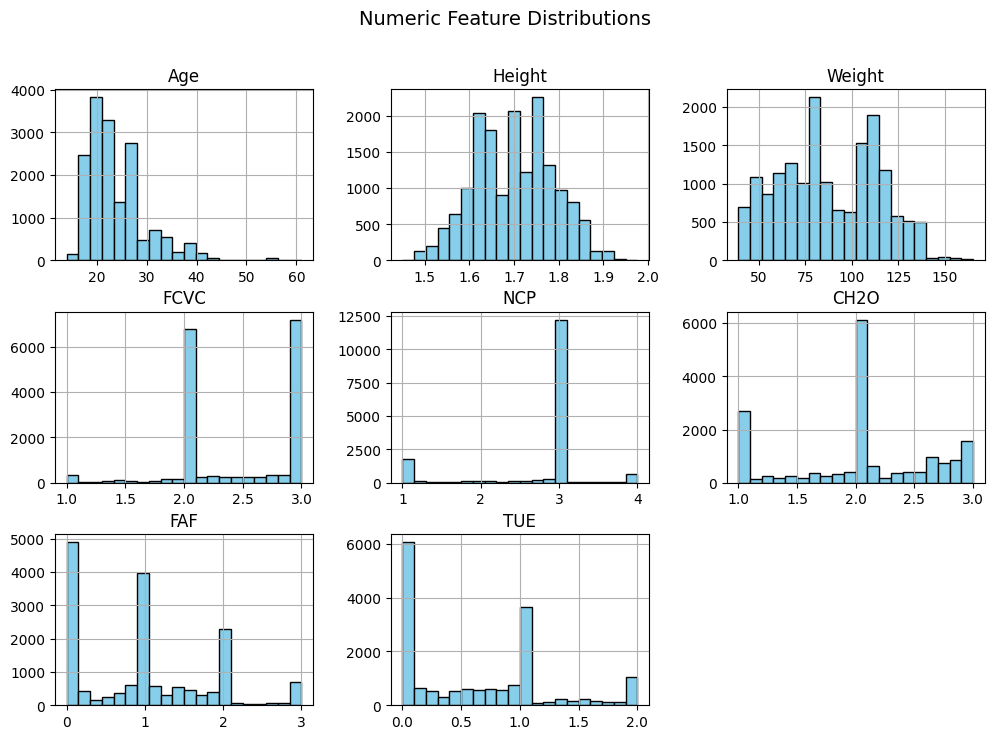

In [9]:
num_cols = train.select_dtypes(include=[np.number]).columns

train[num_cols].hist(figsize=(12, 8), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.show()


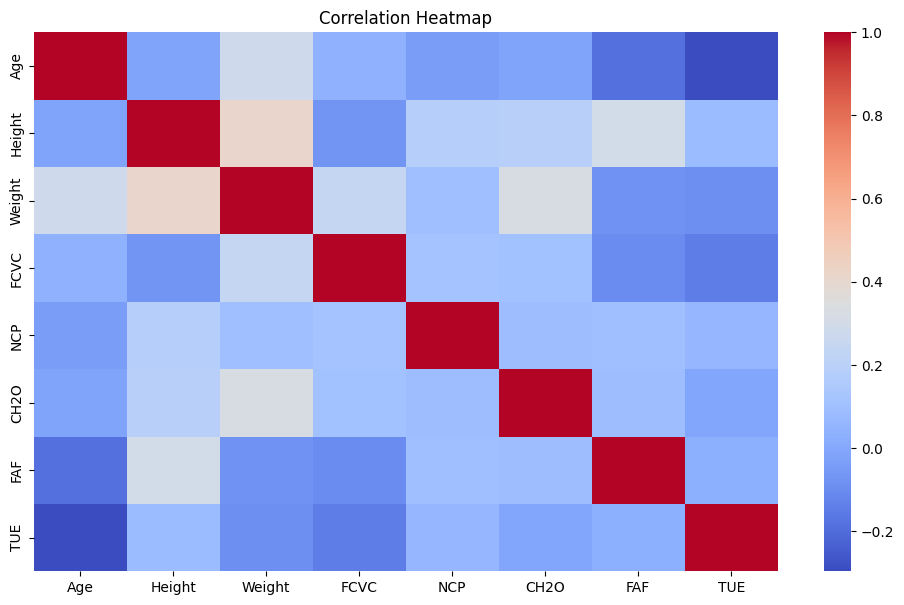

In [10]:
plt.figure(figsize=(12,7))
sns.heatmap(train.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()
